**Project Overview**

Predictive software in math education has long been used in both formalized testing and tutoring and is continually growing in scope. Students benefit from the structure of being shown how to break down a complex math problem and the positive feedback of getting a correct answer. There are many potential uses for software that learns from a student's skillset and learning patterns and offers them related and relevant problems that challenge and encourage them to keep working and immersing themselves in the subject.

As someone who started out in this field designing and teaching standardized test prep courses and working with individual students to predict their strengths and weaknesses, I developed an ability to intuit what types of skills a student would be good at based on what I already knew they were good at. Being able to group together skills to test based on my domain knowledge of the problem gives me a starting point in identifying clusters of similarity between skills.

The KDD Cup competition asks whether it possible to infer the knowledge requirements of math problems directly from student performance data, without human analysis of the tasks. Some questions I will be exploring here to address that: can I predict whether a student will answer an algebra or geometry problem correctly on the first try? If I know that a student is proficient at one commonly-encountered algebra skill, such as combining like terms or removing coefficients, can I predict what other skills they would be proficient at?

**Problem Statement**

Primarily this is a **supervised learning** task, namely a **binary classification** problem, and in the course of working on that problem I expect to do data exploration and some unsupervised learning exploration of potential related categories. The goal of this classification problem is to predict whether the target Correct First Attempt will have a value of 1 (meaning the student answered the step correctly on the first try and received no hints) or 0 (the student did not answer the step correctly on the first try or received hints) for each row. This will be discussed further in the next section.

Part of my goal in this project is to find problems that are similar to each other in terms of student success at those problems. Grouping problems by knowledge components (KCs) involved, I want an answer to the question “if a student does well on problems involving KC , what knowledge components will be present in other problems they tend to do well on?”

One way I can define proficiency at a KC is by looking at the number of times a student answers a question containing a particular KC correctly on the first try as a fraction of how many times they encountered questions containing that KC. This is a simplified assessment; student performance tends to improve over time, so a more detailed model would take temporal relationships into account; students only see remedial problems if they don’t do well on the original problems they are given, so a more detailed model would take such causal relationships into account.

**Metrics**

As discussed in the benchmark model section, this is a binary classification problem and the classes in this dataset are imbalanced (77% of the target values are 1 and 23% are 0). Based on this, I want to focus on maximizing the ability of the model to correctly identify observations in the minority class. As a result I will not be using accuracy as the main metric for evaluating model performance. I will report the following metrics:

- F1 Score 
- AUC/ROC

Both of these methods are effective in measuring not only the rate at which a model provides correct predictions but the rate at which it can correctly predict the minority class. I will discuss more on the dataset and class imbalance in the benchmark model section.

**Data Exploration**

In [12]:
import pandas as pd
import numpy as np
import csv as csv
import matplotlib.pyplot as plt
%matplotlib inline 

pd.set_option('display.max_colwidth', -1)
pd.set_option("display.max_columns", None)

**Dataset and Inputs**

The data I use is provided by PSLC DataShop in the form of records of interactions between students and computer-aided math tutoring software. 

The data is structured into four key components: Problem, Step, Knowledge Component (KC), and Opportunity. More detailed information on the data format can be found [here](https://pslcdatashop.web.cmu.edu/KDDCup/rules_data_format.jsp).

For this data exploration section I am using the 2005-2006 algebra training set, which I will be dividing into training, testing, and cross-validation samples during the model-building process. Some relevant information about this dataset is explored below.

In [2]:
df = pd.read_csv('algebra_2005_2006_train.txt', sep='\t')

print ("This dataset contains {0} rows.".format(df.shape[0]))
print ("This dataset contains {0} columns.".format(df.shape[1]))
print ("This dataset contains {0} unique student IDs.".format(len(df['Anon Student Id'].unique())))

This dataset contains 809694 rows.
This dataset contains 19 columns.
This dataset contains 574 unique student IDs.


Each of the 809694 rows in this dataset corresponds to a **"student-step."** Each problem a student is asked to solve is divided into predetermined steps similar to "Eliminate the parentheses in this expression by distributing x" or "Remove the coefficient from y in this equation." Each step is part of a more complex task, such as, for a geometry problem, finding the surface area of a three-dimensional object.  

Each of the 574 individual student in this dataset is identified by a unique string **Anon Student Id**. The first five rows of the dataframe are shown below.

In [46]:
df.head(5)

,Row,Anon Student Id,Problem Hierarchy,Problem Name,Problem View,Step Name,Step Start Time,First Transaction Time,Correct Transaction Time,Step End Time,Step Duration (sec),Correct Step Duration (sec),Error Step Duration (sec),Correct First Attempt,Incorrects,Hints,Corrects,KC(Default),Opportunity(Default)
0,1,0BrbPbwCMz,"Unit ES_04, Section ES_04-1",EG4-FIXED,1,3(x+2) = 15,2005-09-09 12:24:35.0,2005-09-09 12:24:49.0,2005-09-09 12:25:15.0,2005-09-09 12:25:15.0,40.0,NaN,40.0,0,2,3,1,"[SkillRule: Eliminate Parens; {CLT nested; CLT nested, parens; Distribute Mult right; Distribute Mult left; (+/-x +/-a)/b=c, mult; (+/-x +/-a)*b=c, div; [var expr]/[const expr] = [const expr], multiply; Distribute Division left; Distribute Division right; Distribute both mult left; Distribute both mult right; Distribute both divide left; Distribute both divide right; Distribute subex}]",1
1,2,0BrbPbwCMz,"Unit ES_04, Section ES_04-1",EG4-FIXED,1,x+2 = 5,2005-09-09 12:25:15.0,2005-09-09 12:25:31.0,2005-09-09 12:25:31.0,2005-09-09 12:25:31.0,16.0,16.0,NaN,1,0,0,1,"[SkillRule: Remove constant; {ax+b=c, positive; ax+b=c, negative; x+a=b, positive; x+a=b, negative; [var expr]+[const expr]=[const expr], positive; [var expr]+[const expr]=[const expr], negative; [var expr]+[const expr]=[const expr], all; Combine constants to right; Combine constants to left; a-x=b, positive; a/x+b=c, positive; a/x+b=c, negative}]~~[SkillRule: Isolate positive; x+a=b, positive]",1~~1
2,3,0BrbPbwCMz,"Unit ES_04, Section ES_04-1",EG40,1,2-8y = -4,2005-09-09 12:25:36.0,2005-09-09 12:25:43.0,2005-09-09 12:26:12.0,2005-09-09 12:26:12.0,36.0,NaN,36.0,0,2,3,1,"[SkillRule: Remove constant; {ax+b=c, positive; ax+b=c, negative; x+a=b, positive; x+a=b, negative; [var expr]+[const expr]=[const expr], positive; [var expr]+[const expr]=[const expr], negative; [var expr]+[const expr]=[const expr], all; Combine constants to right; Combine constants to left; a-x=b, positive; a/x+b=c, positive; a/x+b=c, negative}]",2
3,4,0BrbPbwCMz,"Unit ES_04, Section ES_04-1",EG40,1,-8y = -6,2005-09-09 12:26:12.0,2005-09-09 12:26:34.0,2005-09-09 12:26:34.0,2005-09-09 12:26:34.0,22.0,22.0,NaN,1,0,0,1,"[SkillRule: Remove coefficient; {ax+b=c, divide; ax=b; [const expr]*[var fact] + [const expr] = [const expr], divide; [var expr]*[const expr] = [const expr], divide; a/b*x=c; a/b*x=c, reciprocal; ax/b=c, reciprocal; ax/b=c; x/a=b; ax=b; (+/-x +/-a)/b=c, mult; a=x*(b+c); a=x*(b-c); a=x*(b*c+d); x/a+b=c, multiply; [var expr]/[const expr] = [const expr], multiply}]~~[SkillRule: Remove negative coefficient; {ax/b=c, reciprocal; ax/b=c; ax=b; x/a=b}]",1~~1
4,5,0BrbPbwCMz,"Unit ES_04, Section ES_04-1",EG40,2,-7y-5 = -4,2005-09-09 12:26:38.0,2005-09-09 12:28:36.0,2005-09-09 12:28:36.0,2005-09-09 12:28:36.0,118.0,118.0,NaN,1,0,0,1,"[SkillRule: Remove constant; {ax+b=c, positive; ax+b=c, negative; x+a=b, positive; x+a=b, negative; [var expr]+[const expr]=[const expr], positive; [var expr]+[const expr]=[const expr], negative; [var expr]+[const expr]=[const expr], all; Combine constants to right; Combine constants to left; a-x=b, positive; a/x+b=c, positive; a/x+b=c, negative}]~~[SkillRule: ax+b=c, negative; ax+b=c, negative]",3~~1


The target column is **Correct First Attempt** and it will take a value of 1 if the student answered the problem correctly on the first try without asking for a hint from the program, and 0 if they did not.

The feature I will primarily focus on in the initial data exploration will be **KC(Default)**. KCs (knowledge components) are determined by researchers and assigned to each student-step (row). They identify the skills used in solving a step correctly. A full list of KCs in this dataset will be examined below. 

Each row (student-step) contains several KCs. The column **KC(Default)** contains a string of these KC strings separated by tilde (~) characters. KCs can be treated as a categorical variable for this problem. I have split the **KC(Default)** column into individual unique KC strings, one-hot encoded the categorical KCs, and mapped the **Opportunity(Default)** values corresponding to each KC value to each one-hot indicator. I will document and discuss this in detail in the **Data Preprocessing** section.

In [8]:
df_kc = pd.read_pickle('mtunpacked.p') 
df_sum = pd.read_pickle('mtpickle.p') 
df_dict = pd.read_pickle('kclistpickle.p') #dictionary of original/new column names

A full list of all 112 unique KCs is provided below, along with the shortened names I have given them in **Label** to make them easier to access for searching and referencing. I have sorted it in order of the number of rows (student-steps) each KC appears in. The most common KC, **Entering a given**, appears in 76894 different student-steps, or about 9.5% of the full dataset, while the least common KC, **[SkillRule: Do Multiply - Whole nested; [Typei...**, appears in only one student-step.

In [25]:
df_dict.sort_values(by=['Num_KCs'], ascending=False)

,KC,Num_KCs,Label
17,Entering a given,76894,Entering a given
85,"[SkillRule: Remove coefficient; {ax+b=c, divide; ax=b; [const expr]*[var fact] + [const expr] = [const expr], divide; [var expr]*[const expr] = [const expr], divide; a/b*x=c; a/b*x=c, reciprocal; ax/b=c, reciprocal; ax/b=c; x/a=b; ax=b; (+/-x +/-a)/b=c, mult; a=x*(b+c); a=x*(b-c); a=x*(b*c+d); x/a+b=c, multiply; [var expr]/[const expr] = [const expr], multiply}]",62421,SkillRule: Remove coefficient
86,"[SkillRule: Remove constant; {ax+b=c, positive; ax+b=c, negative; x+a=b, positive; x+a=b, negative; [var expr]+[const expr]=[const expr], positive; [var expr]+[const expr]=[const expr], negative; [var expr]+[const expr]=[const expr], all; Combine constants to right; Combine constants to left; a-x=b, positive; a/x+b=c, positive; a/x+b=c, negative}]",53947,SkillRule: Remove constant
60,Using small numbers,51002,Using small numbers
59,Using simple numbers,50830,Using simple numbers
40,Identifying units,37971,Identifying units
0,Changing axis bounds,31950,Changing axis bounds
88,"[SkillRule: Remove positive coefficient; {ax/b=c, reciprocal; ax/b=c; x/a=b; ax=b}]",29002,SkillRule: Remove positive coefficient
57,Using difficult numbers,27052,Using difficult numbers
58,Using large numbers,26884,Using large numbers


In [9]:
d = dict(zip(df_dict['KC'],df_dict['Label']))
df_kc = df_kc.rename(columns = d) #give shorter/more descriptive names to KC columns
df_kc.columns = [c.lower() for c in df_kc.columns] #make column names lowercase for easy access to similar text strings

In [15]:
df_kc.head(5)

,row,changing axis bounds,changing axis intervals,choose graphical refl-v,choose graphical a,choose graphical h,choose graphical k,"convert unit, mixed","convert unit, multiplier","convert unit, standard",correctly placing points,define variable,edit algebraic a,edit algebraic h,edit algebraic k,edit algebraic refl-v,entering a computed linear value,entering a computed quadratic value,entering a given,entering a given linear value,entering a given quadratic value,entering a point,"entering slope, glf","entering slope, sif",entering the slope,entering the y-intercept,"entering x-intercept, glf","entering x-intercept, sif","entering y-intercept, glf","entering y-intercept, sif",excluding the line when shading,"find x, simple","find x, negative slope","find x, positive slope","find y, simple","find y, any form","find y, negative slope","find y, positive slope",identify parent curve,identify parent description,identify parent equation,identifying units,including the line when shading,labelling point of intersection,labelling the axes,"negative constant, glf","negative constant, sif",placing coordinate point,"positive constants, glf","positive constants, sif",setting the slope,setting the y-intercept,shading glf equation with negative slope,shading glf equation with positive slope,shading sif equation with negative slope,shading sif equation with positive slope,shading greater than,shading less than,using difficult numbers,using large numbers,using simple numbers,using small numbers,"write expression, initial and change","write expression, initial and point","write expression, negative slope","write expression, positive slope","write expression, quadratic","write expression, ratio","write expression, two points",skillrule: add/subtract,skillrule: apply exponent,skillrule: calculate eliminate parens,skillrule: calculate negative coefficient,skillrule: consolidate vars with coeff,"skillrule: consolidate vars, any","skillrule: consolidate vars, no coeff",skillrule: do multiply - whole nested,skillrule: done?,skillrule: eliminate parens 1,skillrule: eliminate parens 2,skillrule: extract to consolidate vars,skillrule: isolate negative,skillrule: isolate positive,skillrule: make variable positive 1,skillrule: make variable positive 2,skillrule: multiply/divide,skillrule: remove coefficient,skillrule: remove constant,skillrule: remove negative coefficient,skillrule: remove positive coefficient,skillrule: select combine terms,skillrule: select eliminate parens,"skillrule: select multiply/divide, nested",skillrule: select multiply,skillrule: variable in denominator,"skillrule: ax+b=c, negative",skillrule: done infinite solutions,skillrule: done no solutions,skillrule: invert-mult,combine-like-terms-r-sp,combine-like-terms-sp,combine-like-terms-whole-sp,distribute-sp,factor-quadratic-sp,factor-sp,perform-mult-r-sp,perform-mult-row2-sp,perform-mult-sp,perform-mult-whole-sp,qft-den-sp,qft-num1-sp,qft-num2-sp,simplify-fractions-sp
0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,5,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0

In [16]:
df_kc['Correct First Attempt'] = df_sum['Correct First Attempt']
df_kc['Sum_OCs'] = (df_kc[df_kc.columns[1:113]].astype(int)).sum(axis=1)
df_kc['Num_KCs'] = (df_sum[df_sum.columns[18:130]] == 1).sum(axis=1)

In [23]:
print ("The average transaction in this dataset contains {0} KCs.".format(df_kc['Num_KCs'].mean()))
df_kc['Num_KCs'].value_counts()

The average transaction in this dataset contains 1.0918964448297752 KCs.


1    416511
0    202669
2    107201
3    80373 
4    2680  
5    212   
6    46    
7    2     
Name: Num_KCs, dtype: int64

**Exploratory Visualization**

Over 200,000 rows, or 25% of the dataset, do not have any KCs listed. Two of the rows have 7 KCs listed. Below I am plotting the number of KCs in each transaction against the percentage of Correct First Attempts. 

Rows with NaN values for KCs/OCs are represented as 0s in the unpacked dataset for consistency with rows that do not contain specific KCs, but there are not necessarily zero KCs/OCs present in those steps; we just don't have information on how many KCs/OCs those steps might actually contain. **<- VERIFY** No rows are actually represented in the original dataset as containing 0 KCs/OCs, so we can treat 0 values here as NaN/no information values.

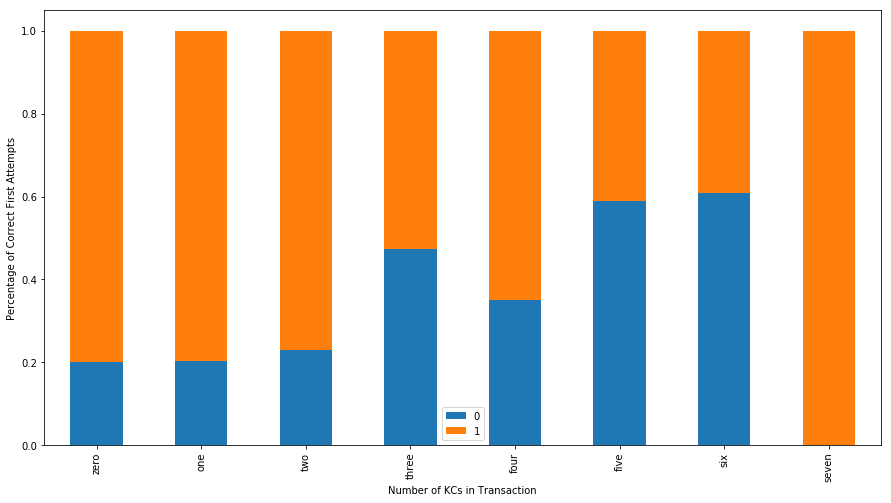

In [30]:
sum_0 = df_kc[df_kc['Num_KCs']==0]['Correct First Attempt'].value_counts(normalize=True)
sum_1 = df_kc[df_kc['Num_KCs']==1]['Correct First Attempt'].value_counts(normalize=True)
sum_2 = df_kc[df_kc['Num_KCs']==2]['Correct First Attempt'].value_counts(normalize=True)
sum_3 = df_kc[df_kc['Num_KCs']==3]['Correct First Attempt'].value_counts(normalize=True)
sum_4 = df_kc[df_kc['Num_KCs']==4]['Correct First Attempt'].value_counts(normalize=True)
sum_5 = df_kc[df_kc['Num_KCs']==5]['Correct First Attempt'].value_counts(normalize=True)
sum_6 = df_kc[df_kc['Num_KCs']==6]['Correct First Attempt'].value_counts(normalize=True)
sum_7 = df_kc[df_kc['Num_KCs']==7]['Correct First Attempt'].value_counts(normalize=True)
df_s = pd.DataFrame([sum_0, sum_1, sum_2, sum_3, sum_4, sum_5, sum_6, sum_7])
df_s.index = ['zero', 'one','two', 'three', 'four', 'five', 'six', 'seven']
df_s.plot(kind='bar',stacked=True, figsize=(15,8))
plt.xlabel('Number of KCs in Transaction')
plt.ylabel('Percentage of Correct First Attempts')

There is a clear relationship between the number of KCs in a transaction and the likelihood of a correct answer. For transactions with zero, one, or two KCs, the likelihood that CFA = 1 is about 80%, and for transactions with five or six KCs that likelihood drops to about 40%. Since there are only two transactions with 7 KCs and both of them have CFAs of 1, we should not treat them as a representative sample. The overall pattern most likely is that more KCs indicates a lower likelihood of a correct initial answer. Reducing the granularity by plotting ranges of KCs makes the pattern more obvious. 

In [31]:
df_kc['KC_Level'] = df_kc['Num_KCs'].map(lambda s: 1 if 0 <= s <=2 else 2 if 3 <= s <= 4 else 3)

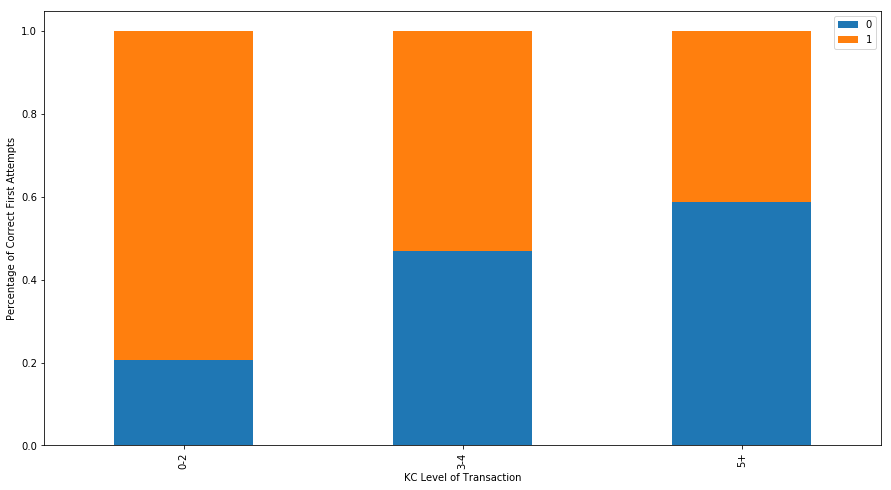

In [39]:
sum_0 = df_kc[df_kc['KC_Level']==1]['Correct First Attempt'].value_counts(normalize=True)
sum_1 = df_kc[df_kc['KC_Level']==2]['Correct First Attempt'].value_counts(normalize=True)
sum_2 = df_kc[df_kc['KC_Level']==3]['Correct First Attempt'].value_counts(normalize=True)
df_s = pd.DataFrame([sum_0, sum_1, sum_2,])
df_s.index = ['0-2', '3-4','5+']
df_s.plot(kind='bar',stacked=True, figsize=(15,8))
plt.xlabel('KC Level of Transaction')
plt.ylabel('Percentage of Correct First Attempts')

It seems clear that the more KCs a student encounters in a step, the less likely they are to get it correct on the first try. 

In [40]:
df_kc[df_kc['KC_Level']==3]['Correct First Attempt'].value_counts(normalize=True)

0    0.588462
1    0.411538
Name: Correct First Attempt, dtype: float64

For steps with 5 or more KCs, the likelihood of a correct first answer is 41%. As we saw above, these transactions make up only a tiny portion of the dataset:

In [41]:
df_kc['KC_Level'].value_counts()

1    726381
2    83053 
3    260   
Name: KC_Level, dtype: int64

In [42]:
260/len(df_kc)

0.00032110896215113363

While steps with 0(NaN), 1, or 2 KCs make up close to 90% of the entire dataset. 

In [72]:
726381/len(df_kc)

0.8971055732165485

In [47]:
df_kc['Num_KCs'].value_counts()

1    416511
0    202669
2    107201
3    80373 
4    2680  
5    212   
6    46    
7    2     
Name: Num_KCs, dtype: int64

Steps containing a single KC alone make up over 50% of the dataset, and steps with 0(NaN) KCs make up about 25%. We are therefore best off focusing on this very large number of potentially misclassified CFA = 0 values for the purposes of building a useful classifier for this dataset. However, knowing the rule about increased KC level leading to fewer CFA = 1 values would certainly be helpful in analyzing a dataset that had more transactions containing a larger number of KCs.

A feature that works in conjuction with KC is Opportunity Count (OC). For each Knowledge Component present in a transaction, the associated OC tells us the number of times the student has already encountered that KC while using the tutoring software. This introduces a temporal dimension to the data. 

As a preliminary way to introduce the OC component into this analysis, I have added up the total OC value of each row (so that a step with two KCs that had each been encountered 5 times would have an OC "sum" of 10). Below I have separated the OCs into buckets to make the visualization easier to follow.

In [58]:
df_kc['OC_Level'] = df_kc['Sum_OCs'].map(lambda s: 0 if 0 == s else 1 if 1 <= s <= 10 else 2
                                                       if 11 <= s <= 20 else 3 if 20 <= s <= 50 else 4
                                                       if 51 <= s <= 100 else 5 if 101 <= s <= 300 else 6
                                                       if 301 <= s <= 500 else 7)

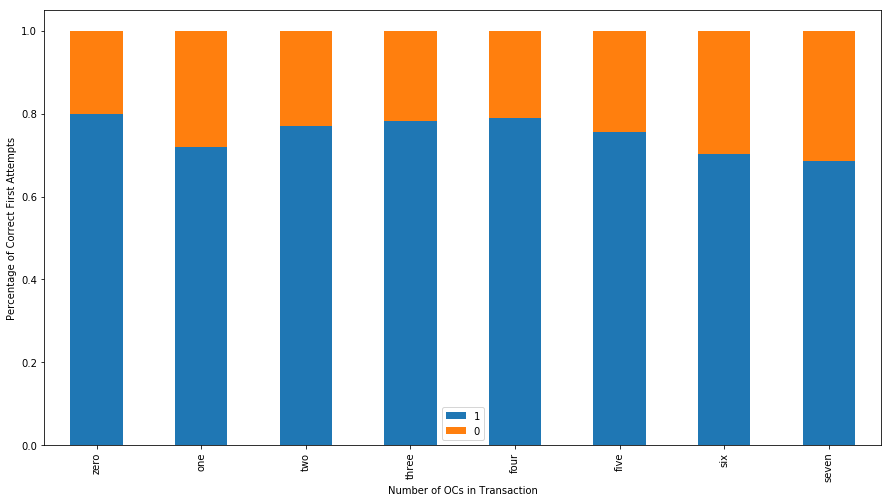

In [60]:
sum_0 = df_kc[df_kc['OC_Level']==0]['Correct First Attempt'].value_counts(normalize=True)
sum_1 = df_kc[df_kc['OC_Level']==1]['Correct First Attempt'].value_counts(normalize=True)
sum_2 = df_kc[df_kc['OC_Level']==2]['Correct First Attempt'].value_counts(normalize=True)
sum_3 = df_kc[df_kc['OC_Level']==3]['Correct First Attempt'].value_counts(normalize=True)
sum_4 = df_kc[df_kc['OC_Level']==4]['Correct First Attempt'].value_counts(normalize=True)
sum_5 = df_kc[df_kc['OC_Level']==5]['Correct First Attempt'].value_counts(normalize=True)
sum_6 = df_kc[df_kc['OC_Level']==6]['Correct First Attempt'].value_counts(normalize=True)
sum_7 = df_kc[df_kc['OC_Level']==7]['Correct First Attempt'].value_counts(normalize=True)
df_s = pd.DataFrame([sum_0, sum_1, sum_2, sum_3, sum_4, sum_5, sum_6, sum_7])
df_s.index = ['zero', 'one','two', 'three', 'four', 'five', 'six', 'seven']
df_s.plot(kind='bar',stacked=True, figsize=(15,8))
plt.xlabel('Number of OCs in Transaction')
plt.ylabel('Percentage of Correct First Attempts')

The leftmost bar above represents 0(NaN) values for both KCs and OCs (i.e. we have no information about the number of KCs they contain and are representing that number as 0). Due to the bucket ranges and sizes chosen, there appears to be a smooth curve in the likelihood of CFA = 1, with a peak around bucket levels 3-4 (20-100 OCs). 

This suggests that students are more likely to get correct answers on questions when they have seen similar questions already, but after a certain point their performance level drops back down at least to where it was when they started. Below I am isolating the transactions for which number of KCs = 1:

In [66]:
df_kc_1 = df_kc[df_kc['Num_KCs'] == 1]

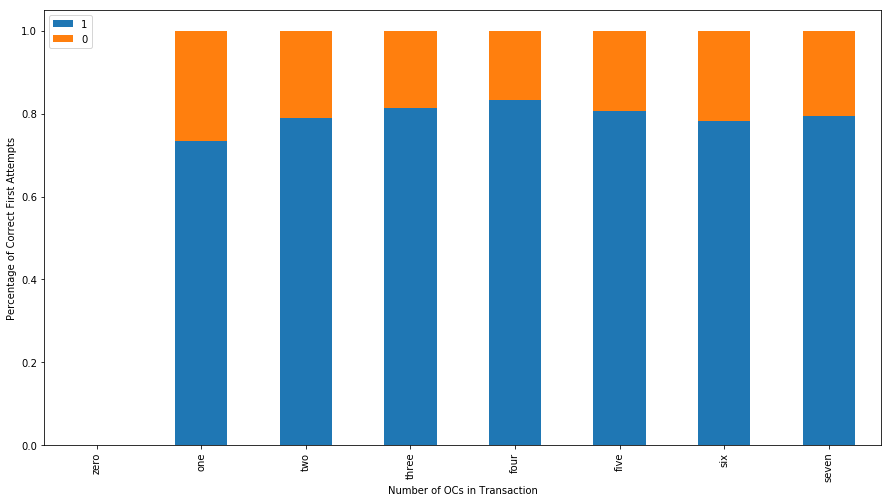

In [68]:
sum_0 = df_kc_1[df_kc_1['OC_Level']==0]['Correct First Attempt'].value_counts(normalize=True)
sum_1 = df_kc_1[df_kc_1['OC_Level']==1]['Correct First Attempt'].value_counts(normalize=True)
sum_2 = df_kc_1[df_kc_1['OC_Level']==2]['Correct First Attempt'].value_counts(normalize=True)
sum_3 = df_kc_1[df_kc_1['OC_Level']==3]['Correct First Attempt'].value_counts(normalize=True)
sum_4 = df_kc_1[df_kc_1['OC_Level']==4]['Correct First Attempt'].value_counts(normalize=True)
sum_5 = df_kc_1[df_kc_1['OC_Level']==5]['Correct First Attempt'].value_counts(normalize=True)
sum_6 = df_kc_1[df_kc_1['OC_Level']==6]['Correct First Attempt'].value_counts(normalize=True)
sum_7 = df_kc_1[df_kc_1['OC_Level']==7]['Correct First Attempt'].value_counts(normalize=True)
df_s = pd.DataFrame([sum_0, sum_1, sum_2, sum_3, sum_4, sum_5, sum_6, sum_7])
df_s.index = ['zero', 'one','two', 'three', 'four', 'five', 'six', 'seven']
df_s.plot(kind='bar',stacked=True, figsize=(15,8))
plt.xlabel('Number of OCs in Transaction')
plt.ylabel('Percentage of Correct First Attempts')

And the transactions for which number of KCs = 2:

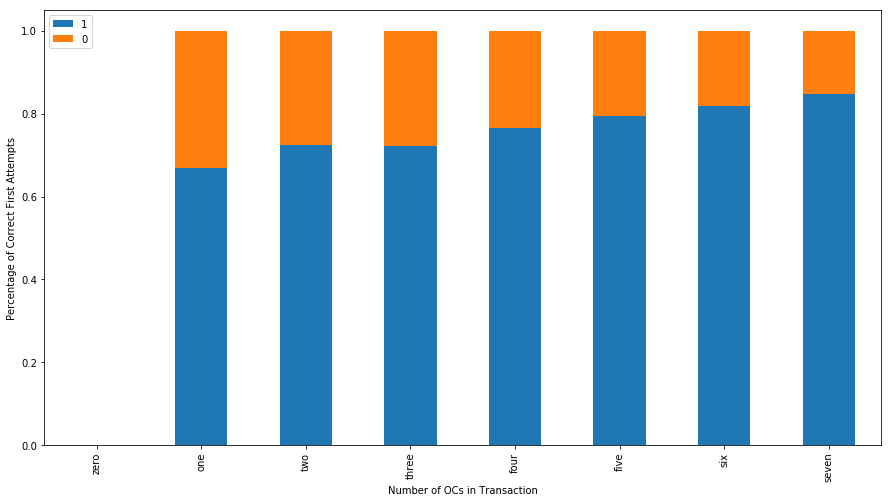

In [70]:
df_kc_2 = df_kc[df_kc['Num_KCs'] == 2]
sum_0 = df_kc_2[df_kc_2['OC_Level']==0]['Correct First Attempt'].value_counts(normalize=True)
sum_1 = df_kc_2[df_kc_2['OC_Level']==1]['Correct First Attempt'].value_counts(normalize=True)
sum_2 = df_kc_2[df_kc_2['OC_Level']==2]['Correct First Attempt'].value_counts(normalize=True)
sum_3 = df_kc_2[df_kc_2['OC_Level']==3]['Correct First Attempt'].value_counts(normalize=True)
sum_4 = df_kc_2[df_kc_2['OC_Level']==4]['Correct First Attempt'].value_counts(normalize=True)
sum_5 = df_kc_2[df_kc_2['OC_Level']==5]['Correct First Attempt'].value_counts(normalize=True)
sum_6 = df_kc_2[df_kc_2['OC_Level']==6]['Correct First Attempt'].value_counts(normalize=True)
sum_7 = df_kc_2[df_kc_2['OC_Level']==7]['Correct First Attempt'].value_counts(normalize=True)
df_s = pd.DataFrame([sum_0, sum_1, sum_2, sum_3, sum_4, sum_5, sum_6, sum_7])
df_s.index = ['zero', 'one','two', 'three', 'four', 'five', 'six', 'seven']
df_s.plot(kind='bar',stacked=True, figsize=(15,8))
plt.xlabel('Number of OCs in Transaction')
plt.ylabel('Percentage of Correct First Attempts')

As discussed above, the transactions with a single KC make up just over 50% of the dataset, and the transactions with two KCs make up 13% of the dataset. (The transactions with 0(NaN) KCs make up about 25% of the dataset, but since we have no information about them regarding these variables we will have to analyze them separately.)

The OC pattern for number of KCs = 1 closely resembles the overall OC pattern, while the pattern for number of KCs = 2 shows a steady increase in the likelihood of correct answers as the number of KCs inreases. Again, because there are fewer of these transactions and their range is smaller, we may not have enough information to extrapolate the true shape of this pattern. 